In [1]:
import os, random
import ntpath
import SimpleITK
from matplotlib import pyplot as plt


## Dataset

Creates the training set using tuples.


a16.mhd
(217, 273, 507)


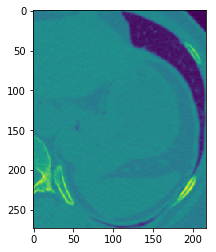

In [3]:
z = 50

workdir = '/projects/0/ismi2018/FINALPROJECTS/CHESTCT_FISSURE_INTEGRITY/'
train_A_images = os.path.join(workdir, 'set-a')
train_B_images = os.path.join(workdir, 'set-b')
train_C_images = os.path.join(workdir, 'set-c')



            
            

train = []
'''
for image in os.listdir(train_A_images):
    if image.endswith('.mhd'):
        train.append((image, 'a'))
for image in os.listdir(train_B_images):
    if image.endswith('.mhd'):
        train.append((image, 'b'))
for image in os.listdir(train_C_images):
    if image.endswith('.mhd'):
        train.append((image, 'c'))
        
'''

case = os.path.join(train_A_images, random.choice(os.listdir(train_A_images)))
case_filename = os.path.splitext(ntpath.basename(case))[0] + '.mhd'
img = SimpleITK.ReadImage(train_A_images+ '/' + case_filename)

piece = SimpleITK.GetArrayViewFromImage(img)[z,:,:]
print(case_filename)
print(img.GetSize())
plt.imshow(piece)


In [4]:
def load_folder(folder, label):
    for image in os.listdir(folder):
        if (image.endswith('.mhd')):
            print(ntpath.basename(image))
        
load_folder(train_A_images, 'a')
        

a07.mhd
a10.mhd
a20.mhd
a00.mhd
a24_lm.mhd
a29_fm.mhd
a07_lm.mhd
a03.mhd
a06_fm.mhd
a01_lm.mhd
a02_lm.mhd
a14_lm.mhd
a02.mhd
a01_fm.mhd
a09_fm.mhd
a25.mhd
a16_lm.mhd
a24.mhd
a08_lm.mhd
a13_lm.mhd
a11.mhd
a01.mhd
a19.mhd
a17_fm.mhd
a28_fm.mhd
a29.mhd
a25_fm.mhd
a17.mhd
a00_lm.mhd
a23.mhd
a10_fm.mhd
a02_fm.mhd
a29_lm.mhd
a18.mhd
a25_lm.mhd
a18_fm.mhd
a11_fm.mhd
a26.mhd
a05.mhd
a00_fm.mhd
a15.mhd
a15_lm.mhd
a13.mhd
a04_fm.mhd
a11_lm.mhd
a15_fm.mhd
a27_lm.mhd
a14.mhd
a28_lm.mhd
a04.mhd
a08.mhd
a03_lm.mhd
a06.mhd
a13_fm.mhd
a10_lm.mhd
a27.mhd
a14_fm.mhd
a09_lm.mhd
a28.mhd
a17_lm.mhd
a16_fm.mhd
a04_lm.mhd
a26_lm.mhd
a16.mhd
a09.mhd
a23_lm.mhd
a06_lm.mhd
a24_fm.mhd
a19_fm.mhd
a18_lm.mhd
a07_fm.mhd
a27_fm.mhd
a03_fm.mhd
a19_lm.mhd
a23_fm.mhd
a26_fm.mhd
